<a href="https://colab.research.google.com/github/DSGPproject/DSGP_model/blob/main/ObjectDetection_transferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **importing nessacary libraries**

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# ***Loading the RESNET MODEL***

In [ ]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/101-classification/versions/2", input_shape=IMAGE_SHAPE+(3,))
])

In [ ]:
# Load pre-trained ResNet model
resnet_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# ***Defining Necessary Variables***

In [ ]:
# Defining image shape
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
IMAGE_SIZE = 224

# ***Loading the Dataset***

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/objectdetection",
    seed=123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

class_names = dataset.class_names
class_names


Found 1766 files belonging to 2 classes.


['Leaves', 'NotLeaves']

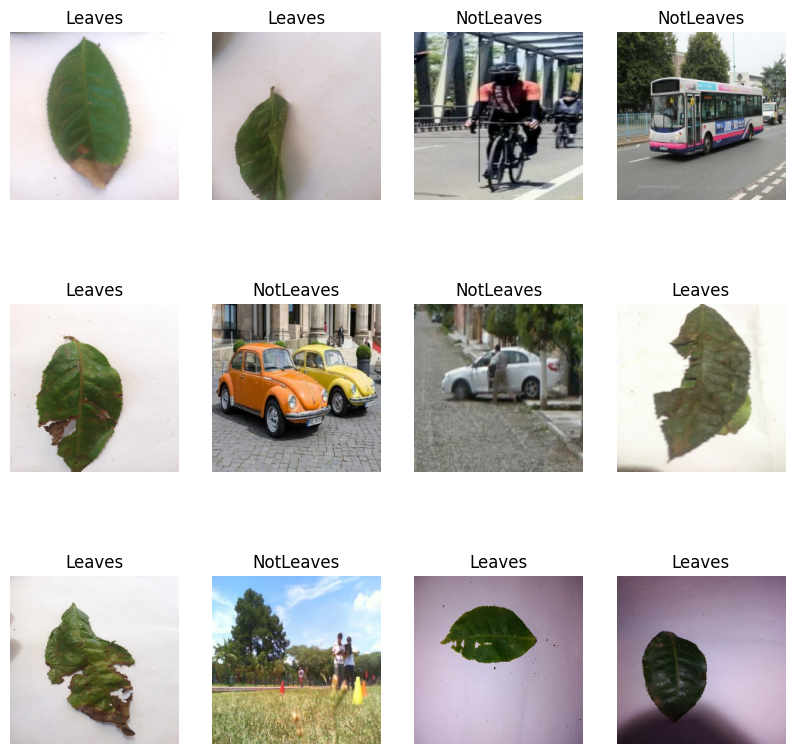

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# ***Model Architecture***

In [ ]:
# Create new model with ResNet base and additional classification layers
model = tf.keras.Sequential([
    resnet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification so its sigmoid
])

In [ ]:
# Compile the model
model.compile(optimizer='adamax',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# ***Function to split the dataset into 3 (test, train, validation)***

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    remaining_ds = ds.skip(train_size)
    val_ds = remaining_ds.take(val_size)
    test_ds = remaining_ds.skip(val_size)

    return train_ds, val_ds, test_ds


# ***splitting the dataset***

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/15
44/44 [==============================] - 1285s 24s/step - loss: 0.0716 - accuracy: 0.9744 - val_loss: 8.3576 - val_accuracy: 0.5125
Epoch 2/15
44/44 [==============================] - 1001s 23s/step - loss: 0.0135 - accuracy: 0.9972 - val_loss: 0.0049 - val_accuracy: 0.9937
Epoch 3/15
44/44 [==============================] - 1003s 23s/step - loss: 0.0072 - accuracy: 0.9986 - val_loss: 2.7943e-05 - val_accuracy: 1.0000
Epoch 4/15
44/44 [==============================] - 1010s 23s/step - loss: 0.0013 - accuracy: 0.9993 - val_loss: 5.1527e-06 - val_accuracy: 1.0000
Epoch 5/15
44/44 [==============================] - 995s 23s/step - loss: 7.6033e-04 - accuracy: 1.0000 - val_loss: 7.8716e-06 - val_accuracy: 1.0000
Epoch 6/15
44/44 [==============================] - 995s 23s/step - loss: 7.1508e-04 - accuracy: 0.9993 - val_loss: 1.2145e-05 - val_accuracy: 1.0000
Epoch 7/15
44/44 [==============================] - 1012s 23s/step - loss: 2.5292e-04 - accuracy: 1.0000 - val_loss: 1.4

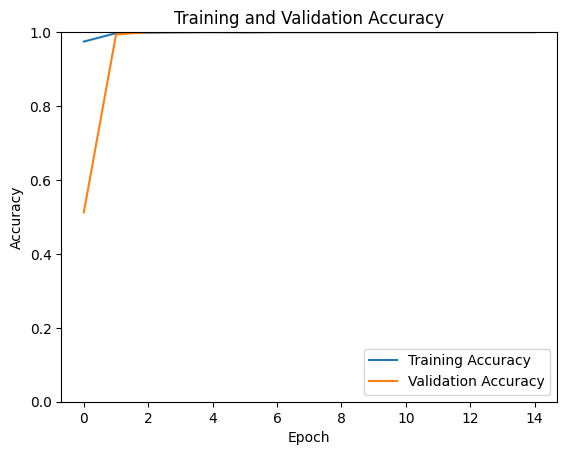

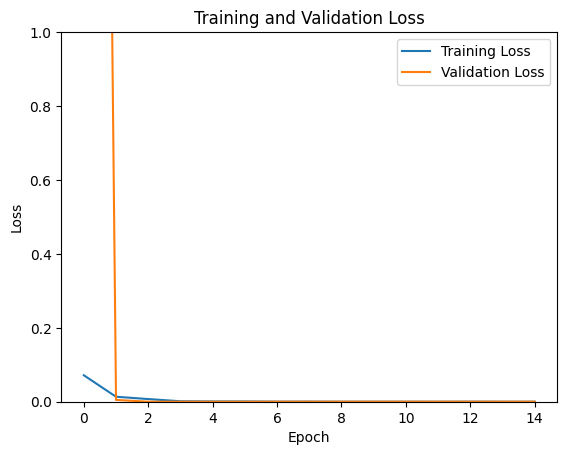

In [ ]:
# Draw training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

# Draw training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import os
from keras.models import load_model

# Replace 'model' with the name of your model
model_name = 'LAST 123final object detection '

# Path to your Google Drive
drive_path = "/content/drive/MyDrive/colab_NoteBooks"

# Full path for saving the model
save_path = os.path.join(drive_path, model_name)

# Save the model
model.save(save_path)

In [ ]:
# Save the model in h5 format
model.save("/content/drive/MyDrive/dataset/LAST_leaf_detection_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/dataset/LAST_leaf_detection_model.h5")

# Make predictions on the test dataset
true_labels = []
predicted_labels = []

for image, label in test_ds:
    true_labels.append(label.numpy())
    predictions = loaded_model.predict(image)
    predicted_labels.append(predictions.squeeze().round())

true_labels = np.concatenate(true_labels)
predicted_labels = np.concatenate(predicted_labels)

# Generating classification report
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

# Generating confusion matrix
matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(matrix)


1/1 [==============================] - 6s 6s/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       119
           1       0.99      1.00      1.00       105

    accuracy                           1.00       224
   macro avg       1.00      1.00      1.00       224
weighted avg       1.00      1.00      1.00       224


Confusion Matrix:
[[118   1]
 [  0 105]]
